---
title: "Post 7 - Exploring Advanced Optimization Methods"
author: Col McDermott
date: "05-05-2025"
description: "An introductory examination of two advanced optimization methods, Newton's Method and Adam, in basic logistic regression"
format: html
code-fold: true
execute:
  warning: false
  message: false
---

# Abstract

In a previous short study, I implemented a basic logistic regression model using two rudimentary versions of gradient descent: standard gradient descent and gradient descent with momentum.  The goals of this past study were to investigate the more basic, fundamental procedures under-the-hood of logistic regression.  Building on my previous work, in this brief study, I will explore more advanced model optimization methods, apply these methods to my preexisting logistic regression implementation, and evaluate/compare their performances.  The two advanced optimization methods I will investigate are **Newton's Method** and **Adam**.

One of the most crucial components of model construction of many ML tools and algorithms (especially linear models) is effective, fast optimization.  Typically, real-world applications of ML models involve massive data sets often containing complex trends and relationships.  Thus, effective model training and fitting can require significant computational resources and time.  Establishing the most efficient (as appropriate) optimization methods is critical in designing practical, functional, and generalizable ML models.  It should be noted that the versions of the optimization methods examined in this study primarily apply to linear models (hence the revisiting of logistic regression), yet the underlying concept of advanced, fast optimization extends to highly complex, non-linear models and algorithms as well.

To explore and compare **Newton's Method** and **Adam** for optimizing a logistic regression model, I have implemented each advanced procedure in my previous logistic regression implementation.  To evaluate the performance and unique properties of each optimization method, I have conducted the following experiments:

Experiments with **Newton's Method**:

1. Displaying the convergence to the correct choice of the weights vector $\mathbf{w}$ with an appropriately selected learning rate $\alpha$.
2. Comparing convergence rates, through the lens of empirical risk minimization, with my previously implemented basic gradient descent methods
3. Investigating the limitation of convergence when the learning rate $\alpha$ is set too large.

Experiments with **Adam**:

1. Displaying the convergence to the correct choice of the weights vector $\mathbf{w} -$ General convergence testing.
2. Comparing convergence rates, through the lens of empirical risk minimization, with standard minibatch stochastic gradient descent using a fixed batch size and altering the step size $\alpha$.

Following the experiments outlined above, I have compared the performance of **Newton's Method** and **Adam**.  Since these techniques employ considerably different computational steps, the comparison of these two advanced optimization methods is conducted as a convergence rate analysis with respect to runtime.  

For the implementation and documentation of the advanced optimization methods outlined above, check out [advanced_logistic.py]().

## Sourcing Data

In order to test, evaluate, compare, and experiment with the advanced optimization methods explored in this study, it is necessary to have some binary classification data.  For this analysis, I will be using the same generated data set from my previous study on [logistic regression](https://col-mcdermott.github.io/posts/post_5/) and the Palmer Penguins data set from my first study on [classification](https://col-mcdermott.github.io/posts/post_1/).  To briefly recap, the first data set is randomly generated 2D binary classification data used to test the correctness of the implementation for each advanced optimization method and the second data set is the widely used penguins classification data set from the Palmer Station collected by Dr. Kristen Gorman.  Rather than trying to classify penguin species, I opted to have my models classify penguin sex (which in this data is a binary classification task).  The penguins data is preprocessed by subsetting out only the numerical-value columns and standardizing each data point (using $\frac{\mathbf{x} - \mu}{\sigma}$ where $\mu, \sigma$ are the mean and STD. of the data).

In [668]:
# Including all additional imports
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pdf2image import convert_from_path
from matplotlib import pyplot as plt
from IPython.display import Image
import torch as tch
import pandas as pd
import numpy as np
import time

# Porting over logistic regression implementation
%load_ext autoreload
%autoreload 2
from advanced_logistic import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer, AdamOptimizer
tch.manual_seed(100) # For consistent data generation
plt.style.use('seaborn-v0_8-whitegrid') # For consistent plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


*Code above imports all necessary packages/libraries and ports over the implementation of my logistic regression model and the advanced optimizers `NewtonOptimizer` and `AdamOptimizer`.*

In [669]:
# Generating data for binary classification - code provided by Prof. Chodrow
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    y = tch.arange(n_points) >= int(n_points / 2)
    y = 1.0 * y
    X = y[:, None] + tch.normal(0.0, noise, size = (n_points,p_dims))
    X = tch.cat((X, tch.ones((X.shape[0], 1))), 1)
    
    return X, y
X_sim, y_sim = classification_data(noise = 0.25)

# Accessing penguins data - data and (edited) method provided by Prof. Chodrow
def prepare_data(df):
  
  # Preprocessing data
  le = LabelEncoder()
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  le.fit(train["Sex"])
  df = df.dropna()
  y = le.transform(df["Sex"])
  df = df.drop(["Sex", "Species", "Island", "Stage", "Clutch Completion"], axis = 1)
  
  # Converting to torch tensors
  X = tch.tensor(df.values).float()
  y_ = tch.tensor(y == 1).float()

  # Standardizing the data
  mean = tch.mean(X, dim = 0, keepdim = True)
  std = tch.std(X, dim = 0, keepdim = True)
  X_s = (X - mean) / std
  
  # Adding a col of 1s to feature matrix
  X_s = tch.cat((X_s, tch.ones(X_s.size(0), 1)), dim=1)
  return X_s, y_

train = pd.read_csv("https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv")
X_train, y_train = prepare_data(train)

*Code above generates the simulated data (generated with fairly low-noise to ensure linear separability) and imports, preprocess (feature subsetting and standardization), the empirical (real-world) data (some code provided by Prof. Chodrow).*

In [670]:
# Model interpretation helper methods
## Loss value plotter
def loss_plot(ax, loss_vec1, loss_vec2 = None):
    # Plotting the loss values of the model across each optimization iteration
    ax.plot(loss_vec1, color = "#A46AAE", linewidth = 2)
    title = "Evolution of Empirical Loss Value"
    if (loss_vec2 != None):
        title = "Gradient Descent Method Comparison\nof Empirical Loss Value Convergence"
        ax.plot(loss_vec2, color = "darkcyan", linewidth = 2)
        ax.legend(["Standard", "Momentum"], frameon = True)
        ax.axhline(loss_vec2[-2], color = "black", linestyle = "--")
    ax.set_title(title)
    ax.set_xlabel("Optimization Iteration")
    ax.set_ylabel("Loss")
    plt.tight_layout()

# Model accuracy plotter
def acc_plot(accs1, accs2 = None):
    
    # Plotting the accuracies of the model across each optimization iteration
    fig, ax = plt.subplots(1, 1, figsize = (5, 5))
    ax.plot(accs1, color = "purple", linewidth = 2)
    if (accs2 != None):
        ax.plot(accs2, color = "darkcyan", linewidth = 2)
        ax.legend(["Training Accuracy", "Testing Accuracy"], frameon = True)
    ax.set_title("Model Accuracy Across Optimization Iteration")
    ax.set_xlabel(r"Gradient Descent Iteration")
    ax.set_ylabel("Accuarcy")
    plt.tight_layout()

# Decision line plotting helper method - code provided by Prof. Chodrow
def draw_line(X, w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = tch.linspace(x_min, x_max, X.shape[0])
    y = -1 * (((w_[0] * x) + w_[2])/w_[1])
    ax.plot(x, y, **kwargs)

# Decision region plotter
def decision_bound(model, X, y, ax):

    # Creating a mesh grid
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    
    # Drawing the decision line
    draw_line(X, model.w, x_min, x_max, ax, color = "black", linewidth = 2)
    targets = [0, 1]
    markers = ["o" , ","]

    # Custom color map
    colors = ["#A46AAE", "darkcyan"]  
    cmap = LinearSegmentedColormap.from_list("my_cmap", colors, N=256)

    # Some code below provided by Prof. Chodrow
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix, 0], X[ix, 1], s = 20,  c = 2 * y[ix] - 1, facecolors = "none", edgecolors = "none", cmap = cmap, vmin = -2, vmax = 2, alpha = 0.75, marker = markers[i])
    
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    ax.set_title("Decision Regions of Logistic Regression Model")
    ax.text(X[:, 0].max() * 0.8, X[:, 1].max() * 0.85, f"Model Accuracy:\n{round(acc(model, X, y), 4) * 100}%", fontsize = 10, ha = "center", bbox = dict(facecolor = "white", alpha = 0.75, edgecolor = "gray", boxstyle = "round,pad = 0.3"))
    plt.tight_layout()

# Function to calculate model accuracy
def acc(model, X, y):
    
    # Compute model predictions
    preds = model.predict(X)

    # Determine the number of correct predictions
    correct_preds = ((preds == y) * 1).float()

    # Return the rate of correct predictions
    return tch.mean(correct_preds).item()

*Code above defines plotting methods for observing the model's empirical loss value evolution, the model's accuracy, and the model's classification decision boundaries (some code provided by Prof. Chodrow).*

## Implementing Newton's Method

The implementation of Newton's method incorporates the `LinearModel` and extends the `LogisticRegression` class implementations from my [previous study](https://col-mcdermott.github.io/posts/post_5/).  Extending the `LogisticRegression` class:

-   `hessian(X)`: A method that computes the Hessian matrix $H(\mathbf{w})$ of the empirical loss function $L(\mathbf{w})$ with respect to the weights vector $\mathbf{w}$.  This Hessian matrix is a key component of Newton's method which is a second-order optimization technique.  The Hessian can be computed using matrix multiplication involving the feature matrix $\mathbf{X}$ and diagonal matrix $\mathbf{D}$ where the diagonal entries of $\mathbf{D}$ are $d_{k, k} = \sigma(s_k)(1 - \sigma(s_k))$ (where $s_k$ is the score of the kth data point).  Note that to ensure numerical stability and matrix singularity, the Hessian $H(\mathbf{w})$ is normalized by the $n$ (the number of data points $\mathbf{X}$) and has diagonal entries padded by a value $\epsilon = 1\times10^-10$.  I found that these precautionary additions made for better experimentation.  Below is the explicit definition of $H(\mathbf{w})$ along with the formula defining each entry $h_{i, j}(\mathbf{w})$:

$$
\begin{align*}
\mathbf{H}(\mathbf{w}) &= \mathbf{X}^T\mathbf{D}\mathbf{X} \\
h_{i, j}(\mathbf{w}) &= \sum_{k = 1}^{n}{x_{k, i}x_{k, j}\sigma(s_k)(1 - \sigma(s_k))}
\end{align*}
$$

The actual implementation of Newton's method resides in the following class:

**`NewtonOptimizer`**:

-   `self.lr`: An instance variable of a `LogisticRegression` object.  This is used to reference the current weights vector $\mathbf{w}$ during an optimization step.

-   `step(X, y, alpha)`: A method that computes an optimization step of Newton's method.  Note that $\mathbf{X}, \mathbf{y}$ are needed to compute the gradient and Hessian matrix of the loss function $L(\mathbf{w})$.  The hyperparameter `alpha` (denoted as $\alpha$ below) is used to set the learning rate for the gradient descent process.  Note that this method technically takes the Moore-Penrose pseudoinverse of the Hessian $\mathbf{H(w)}$ to avoid computational failure in the event $\mathbf{H(w)}$ is somehow non-singular (likely due to finite numerical precision).  I again found that this precautionary change made for better experimentation.  This method updates the weights vector $\mathbf{w_k}$ using the following:

$$
w_{k + 1} = w_{k} - \alpha \mathbf{H^{-1}}(\mathbf{w_{k}})\nabla L(\mathbf{w_{k}})
$$

-   `optimize(X, y, alpha, tol)`: A method to optimize a model with Newton's method (repeatedly calling the `step(X, y, alpha)` method above) until the model's empirical loss value reaches the desired loss-value tolerance (`tol`).

### Experiment 1: Testing The Implementation of Newton's Method

To test my implementation of Newton's method, I will evaluate its performance on the generated data in comparison to the standard gradient descent method I implemented in a previous study.  

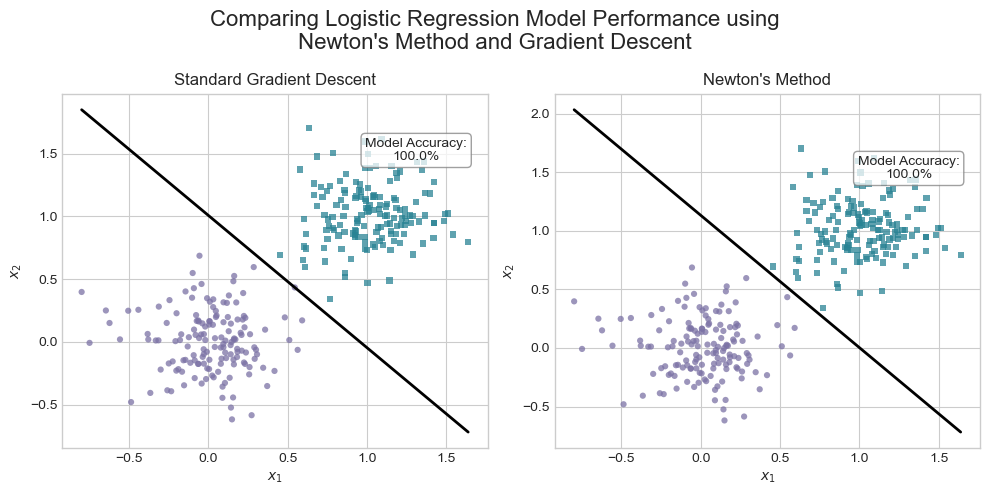

In [671]:
# Testing the correctness of Newton's method implementation
## Logistic regression model for Standard gradient descent
LR_s = LogisticRegression()
opt_s = GradientDescentOptimizer(LR_s)

# Logistic regression model for Newton's method
LR_n = LogisticRegression()
opt_n = NewtonOptimizer(LR_n)

# Initializing an equal weights vector for each model
LR_s.w = tch.rand((X_sim.size()[1]))
LR_n.w = LR_s.w

# Optimizing both models
for i in range(5000):

    opt_s.step(X_sim, y_sim, alpha = 0.1, beta = 0.0)
    opt_n.step(X_sim, y_sim, alpha = 0.1)

# Plotting the decision regions of both models
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
decision_bound(LR_s, X_sim, y_sim, ax[0])
decision_bound(LR_n, X_sim, y_sim, ax[1])
ax[0].set_title("Standard Gradient Descent")
ax[1].set_title("Newton's Method")
fig.suptitle("Comparing Logistic Regression Model Performance using\nNewton's Method and Gradient Descent", fontsize = 16)
plt.tight_layout()

**Figure 1**

In [672]:
# Displaying the weights vectors of both models
print(f"Standard Gradient Descent Optimizer | w_s = {LR_s.w.flatten()}\n----------")
print(f"Newton's Method Optimizer           | w_n = {LR_n.w.flatten()}")

Standard Gradient Descent Optimizer | w_s = tensor([ 5.6146,  5.3198, -5.3680])
----------
Newton's Method Optimizer           | w_n = tensor([ 251.7622,  222.9369, -252.3581])


*Code cells above optimize two logistic regression models using the `NewtonOptimizer` and `GradientDescentOptimizer`, plot the corresponding decision boundaries, and display the weights vectors $w_s$ (for standard gradient descent) and $w_n$ (for Newton's method).*

The figure above shows the decision boundaries for the two logistic regression models fit to the simulated classification data.  One model was optimized using standard gradient descent and the other was optimized using Newton's method.  As shown in the plots above, the decision boundaries for each model appear essentially identical and both models were able to achieve $100\%$ classification accuracy.  This is expected as the data is generated to be linearly separable.  Interestingly though, the output above shows that the weights vectors $\mathbf{w_s}$ (for standard gradient descent) and $\mathbf{w_n}$ (for Newton's method) are notably different for each entry.  This is likely attributable to the fact standard gradient descent and Newton's method involve similarly-formatted by considerably differently-valued calculations.  Nonetheless, each model was still able to converge to a "correct" weights vector $\mathbf{w}$.  Note that for both the standard gradient descent and Newton's method optimizers, the learning rate $\alpha$ was set to $0.1$ (for the standard gradient descent optimizer, the momentum scalar $\beta$ was set to $0.0$).  This shows that with a sufficiently small learning rate, both optimizers can converge to the same weights vector $\mathbf{w}$ and yield the same model accuracy.

### Experiment 2: Comparing Convergence Rates 

For this experiment, I will compare the convergence rates of two logistic regression models optimized using the `NewtonOptimizer` and `GradientDescentOptimizer`.  Each model will be trained and tested on the empirical, real-world data set.

In [673]:
# Comparing convergence rates of standard gradient descent and Newton's method
## Logistic regression model for Standard gradient descent
LR_s = LogisticRegression()
opt_s = GradientDescentOptimizer(LR_s)

# Logistic regression model for Newton's method
LR_n = LogisticRegression()
opt_n = NewtonOptimizer(LR_n)

# Initializing an equal weights vector for each model
LR_s.w = tch.rand((X_train.size()[1]))
LR_n.w = LR_s.w

# Arrays to store the loss values of the models optimized with grad. descent and Newton's method
losses_s = []
losses_n = []
tol = 0.315
at_tol = False
i = 0

# Iteration counters to track convergence
s_i = np.iinfo(np.int64).max
n_i = np.iinfo(np.int64).max
while (at_tol != True):
    
    # Recording current loss values
    loss_s = LR_s.loss(X_train, y_train)
    loss_n = LR_n.loss(X_train, y_train)
    if (loss_s > tol):
        losses_s.append(loss_s)
        opt_s.step(X_train, y_train, alpha = 0.1, beta = 0.0)
    elif (s_i > i):
        s_i = i
    if (loss_n > tol):
        losses_n.append(loss_n)
        opt_n.step(X_train, y_train, alpha = 0.1)
    elif (n_i > i):
        n_i = i
    
    # Terminating condition
    if (loss_s < tol) & (loss_n < tol):
        at_tol = True
    
    # Displaying gradient descent progress for 5 iterations
    if (i % 20 == 0) & (i < 100):
        print(f"Iteration {i}:")
        print(f"Current Loss value (Standard Gradient Descent): {round(losses_s[-1], 3)}")
        print(f"Current Loss value (Newton's Method):           {round(losses_n[-1], 3)}\n----------\n")
    i += 1

print("...\n")
print(f"Standard Gradient Descent Converges at {s_i} Iterations")
print(f"Newton's Method Converges at           {n_i} Iterations")

Iteration 0:
Current Loss value (Standard Gradient Descent): 2.071
Current Loss value (Newton's Method):           2.071
----------

Iteration 20:
Current Loss value (Standard Gradient Descent): 1.18
Current Loss value (Newton's Method):           0.405
----------

Iteration 40:
Current Loss value (Standard Gradient Descent): 0.826
Current Loss value (Newton's Method):           0.316
----------

Iteration 60:
Current Loss value (Standard Gradient Descent): 0.685
Current Loss value (Newton's Method):           0.316
----------

Iteration 80:
Current Loss value (Standard Gradient Descent): 0.61
Current Loss value (Newton's Method):           0.316
----------

...

Standard Gradient Descent Converges at 1666 Iterations
Newton's Method Converges at           36 Iterations


*Code above compares the convergence rates of the empirical loss value of the two logistic regression models optimized using the `NewtonOptimizer` and `GradientDescentOptimizer`.  Each model is optimized until its empirical loss value is less than the tolerance of $0.325$.  Note that the learning rate $\alpha$ for the `GradientDescentOptimizer` was set to $0.1$ and the momentum scalar $\beta$ was set to $0.0$.  The learning rate $\alpha$ for the `NewtonOptimizer` was set to $0.1$.*

The output above displays a comparison of the convergence rates of the two logistic regression models optimized using the `NewtonOptimizer` and `GradientDescentOptimizer`.  Note that the learning rate $\alpha_s$ for the `GradientDescentOptimizer` was set to $0.1$, the momentum scalar $\beta$ was set to $0.0$, and the learning rate $\alpha_n$ for the `NewtonOptimizer` was set to $0.1$.  To compare the convergence of the empirical loss value, each model was optimized until its empirical loss value was less than the tolerance of $0.315$.  As illustrated above, the model optimized with Newton's method converged much faster (~$46\times$ quicker) than the model optimized with standard gradient descent.  

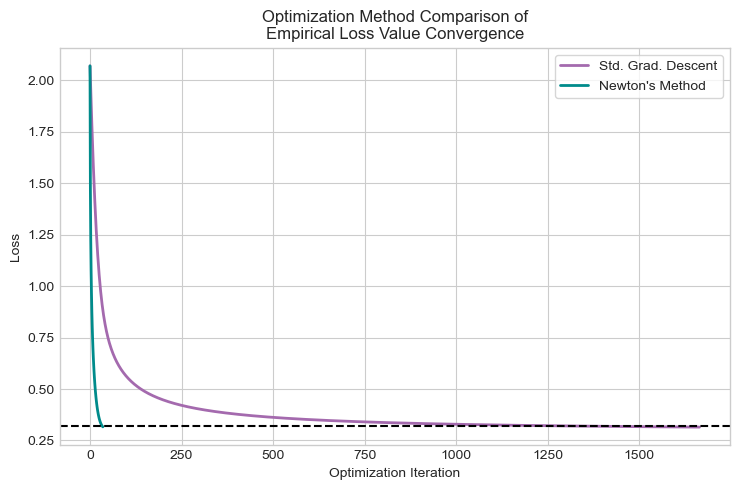

In [674]:
# Plotting the loss values of both models
fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))
loss_plot(ax, losses_s, losses_n)
ax.legend(["Std. Grad. Descent", "Newton's Method"], frameon = True)
ax.set_title("Optimization Method Comparison of\nEmpirical Loss Value Convergence")
plt.tight_layout()

*Code above plots the empirical loss value convergence rates for each of the logistic regression models optimized using the `NewtonOptimizer` and `GradientDescentOptimizer`.*

**Figure 2**

The plot above provides a visual accompaniment to the output produced by the previous code cell.  As shown, the model optimized with Newton's method converges significantly faster than the model optimized with standard gradient descent.  This result is evidence that under certain circumstances (i.e. when the learning rates $\alpha_n, \alpha_s$ are appropriately/independently set), Newton's method can achieve convergence (in the context of decreasing empirical loss value) considerably faster than standard gradient descent.  Overall this experiment provides strong justification for why Newton's method is considered significantly more efficient for optimization over standard gradient descent (under the right circumstances that is).

### Experiment 3: Investigating the Limitation of Convergence

In this experiment, I will investigate the limitations of convergence of Newton's method when the learning rate $\alpha$ is set too large.

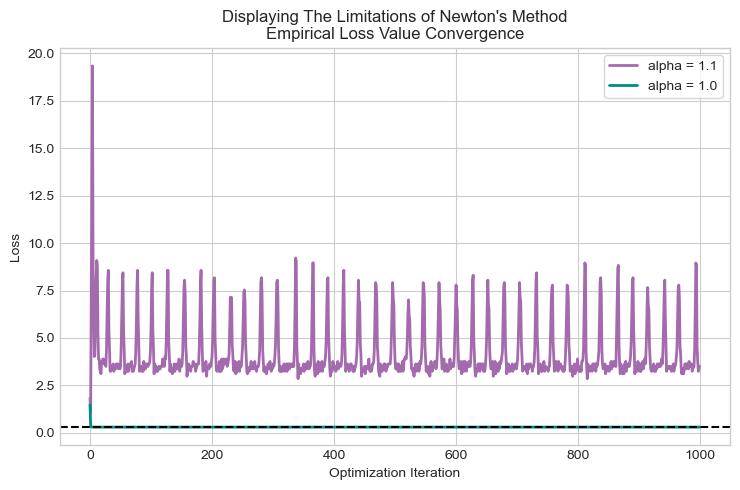

In [675]:
# Investigating the limitations of convergence of Newton's method

# Logistic regression models with Newton's method using a large and small learning rate
LR_lg = LogisticRegression()
opt_lg = NewtonOptimizer(LR_lg)
LR_sm = LogisticRegression()
opt_sm = NewtonOptimizer(LR_sm)

# Arrays to store the loss values of the model optimized with Newton's method
losses_lg = []
losses_sm = []

for i in range(1000):
    
    # Recording current loss value
    loss_lg = LR_lg.loss(X_train, y_train)
    loss_sm = LR_sm.loss(X_train, y_train)
    losses_lg.append(loss_lg)
    losses_sm.append(loss_sm)
    opt_lg.step(X_train, y_train, alpha = 1.1)
    opt_sm.step(X_train, y_train, alpha = 1.0)

# Plotting the loss values of both models
fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))
loss_plot(ax, losses_sm, losses_lg)
ax.set_title("Displaying The Limitations of Newton's Method\nEmpirical Loss Value Convergence")
ax.legend(["alpha = 1.1", "alpha = 1.0"], frameon = True)
plt.tight_layout()

*Code above optimizes two logistic regression models with a `NewtonOptimizer` and plots the evolution of the empirical loss values over $1000$ iterations.  The learning rates are set to $\alpha_{sm} = 1.0, \alpha_{lg} = 1.1$.*

**Figure 3**

The figure above illustrates the limitations of convergence of Newton's method when the learning rate $\alpha$ is set to large.  In the plot, the evolution of the empirical loss values of two logistic regression models optimized with Newton's method is displayed.  One of the models has a learning rate of $\alpha_{sm} = 1.0$, while the other has a learning rate of $\alpha_{lg} = 1.1$.  When the learning rate is set to $1.0$, the model is able to converge to the minimal empirical loss value in very few iterations.  However, when the learning rate is slightly increased to just $1.1$, the model fails to converge to neither the minimal nor a consistent empirical loss value.  Overall, it is clear that with a poorly/too-large selected learning rate, a model optimized with Newton's method will fail to converge (with respect to decreasing empirical loss).  This experiment stands as evidence that while Newton's method can strongly outperform less efficient optimization methods under some circumstances, this will not strictly be the case as Newton's method risks failing to optimize overall in some scenarios.

## Implementing The Adam Optimization Algorithm

Like the implementation of Newton's method, the implementation of the Adam algorithm incorporates the `LinearModel` and the `LogisticRegression` class implementations from my previous study. The Adam algorithm is defined in the following class:

**`AdamOptimizer`**:

-   `self.lr`: An instance variable of a `LogisticRegression` object.  This is used to reference the current weights vector $\mathbf{w}$ during an optimization step.

-   `optimizeEpoch(X, y, batch_size, alpha, beta_1, beta_2, w_0 = None)`:  A method that computes runs the Adam algorithm on the data over one epoch.  The `batch_size` argument specifies the size of the subset of data from the feature matrix $\mathbf{X}$ used in the improved stochastic gradient descent processed.  The arguments `beta_1`, `beta_2` determine the decay rates of the first moment (the mean of the gradient) and the second raw moment (the un-centered variance of the gradient) respectively.  The `w_0` argument is the initial guess for the weights vector $\mathbf{w}$ (implicitly set to `None`).

-   `optimize(X, y, tol, batch_size, alpha, beta_1, beta_2, w_0 = None)`: A method that runs the Adam algorithm on the data until the model's empirical loss value reaches the desired tolerance (`tol`).

The Adam algorithm is a more efficient stochastic gradient descent technique that only uses first-order information.  The Adam method leverages several efficiency-promoting concepts including the incorporation of adaptive learning rates $-$ using the first and second moments of the gradient to give parameters with larger gradient magnitudes smaller updates and the opposite for parameters with smaller gradient magnitudes. My implementation of the Adam algorithm is defined below (adapted from Kingma, Diederik P, and Jimmy Lei Ba):

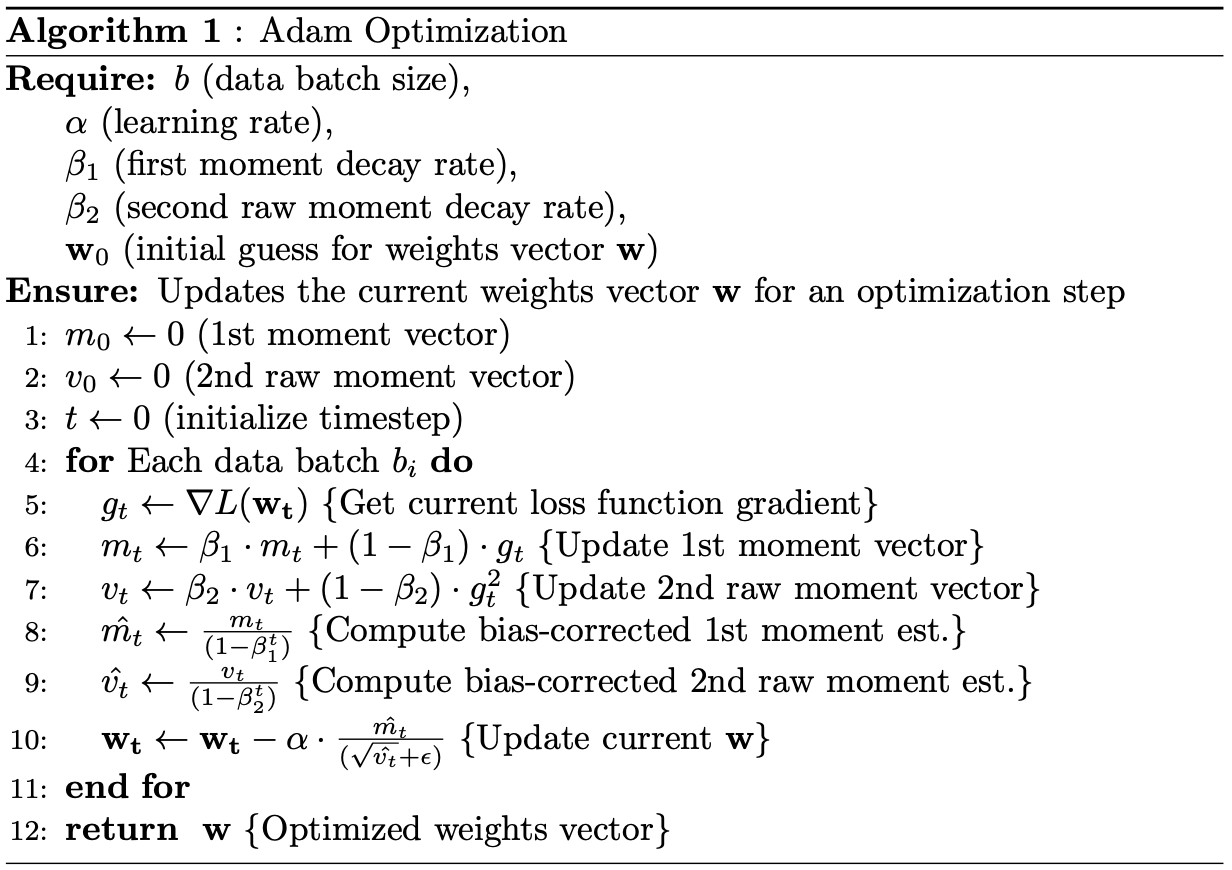

In [676]:
Image(filename = "adam.png")

**Image 1**

Above is the pseudocode for my implementation of the Adam algorithm which is a slightly edited version of the original algorithm designed by Kingma, Diederik P, and Jimmy Lei Ba.

### Experiment 1: Testing the Implementation of Adam

To examine the correctness of my implementation of the Adam algorithm, I will again evaluate its performance on the generated data in comparison to the standard gradient descent method from my previous study.

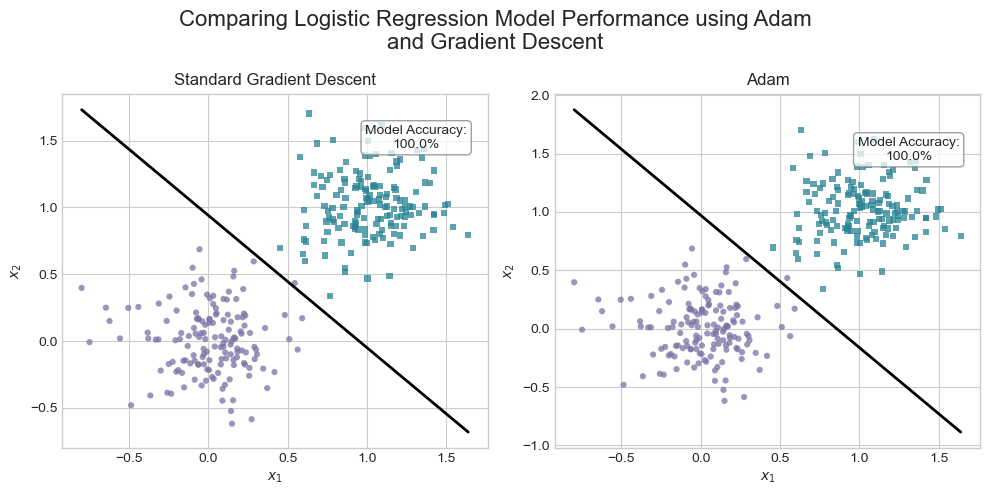

In [677]:
# Testing the correctness of Adam implementation
## Logistic regression model for Standard gradient descent
LR_s = LogisticRegression()
opt_s = GradientDescentOptimizer(LR_s)

# Logistic regression model for adam
LR_a = LogisticRegression()
opt_a = AdamOptimizer(LR_a)

# Initializing an equal weights vector for each model
LR_s.w = tch.rand((X_sim.size()[1]))
LR_a.w = LR_s.w

# Optimizing both models
for i in range(1000):
    opt_s.step(X_sim, y_sim, alpha = 0.1, beta = 0.0)
    
    # # Optimizing with Adam for 3 epochs
    if (i % 333 == 0):
        
        # Using a batchsize of (n/10) and the other suggested default argument settings
        opt_a.optimizeEpoch(X_sim, y_sim, batch_size = int(X_sim.size(0) / 10), alpha = 0.1, beta_1 = 0.9, beta_2 = 0.9, w_0 = LR_a.w)

# Plotting the decision regions of both models
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
decision_bound(LR_s, X_sim, y_sim, ax[0])
decision_bound(LR_a, X_sim, y_sim, ax[1])
ax[0].set_title("Standard Gradient Descent")
ax[1].set_title("Adam")
fig.suptitle("Comparing Logistic Regression Model Performance using Adam\nand Gradient Descent", fontsize = 16)
plt.tight_layout()

**Figure 4**

In [678]:
# Displaying the weights vectors of both models
print(f"Standard Gradient Descent Optimizer | w_s = {LR_s.w.flatten()}\n----------")
print(f"Adam Optimizer                      | w_a = {LR_a.w.flatten()}")

Standard Gradient Descent Optimizer | w_s = tensor([ 3.4320,  3.4643, -3.2607])
----------
Adam Optimizer                      | w_a = tensor([ 4.0078,  3.5353, -3.4335])


*Code cells above optimize two logistic regression models using the `GradientDescentOptimizer` and `AdamOptimizer`, plot the corresponding decision boundaries, and display the weights vectors $w_s$ (for standard gradient descent) and $w_a$ (for Adam).*

Similarly to **Figure 1**, the figure above shows the decision boundaries for two logistic regression models fit to the simulated classification data.  One model was optimized using standard gradient descent and the other was optimized using the Adam algorithm.  As shown in the plots above, the decision boundaries for each model appear essentially identical and both models were able to achieve $100\%$ classification accuracy.  This is expected as the data is generated to be linearly separable.  In this experiment, the model optimized with standard gradient descent was optimized over $1000$ iterations while the model optimized with the Adam algorithm was run for $3$ epochs.  Additionally, the output above shows that the weights vectors $\mathbf{w_s}$ (for standard gradient descent) and $\mathbf{w_a}$ (for the Adam algorithm) have very similar corresponding entries.  Interestingly, the weights vectors $\mathbf{w_s}, \mathbf{w_a}$ are not identical, yet they both yield models with flawless classification ability on the generated data.  Note that for both the standard gradient descent and Adam algorithm optimizers, the learning rate $\alpha$ was set to $0.1$, and the initial weights vector $\mathbf{w_0}$ was set randomly and assigned to each model. For the standard gradient descent optimizer, the momentum scalar $\beta$ was set to $0.0$.  For the Adam optimizer, the remaining parameters were set to: `batch_size` = $\frac{n}{10}$, and $\beta_1, \beta_2 = 0.9$.  This shows that with adequately chosen learning rates and other hyperparameters, both optimizers can converge to the same weights vector $\mathbf{w}$ and yield the same model accuracy.

### Experiment 2: Comparing Convergence Rates Between Adam and Standard SGD (Stochastic Gradient Descent)

This experiment aims to display the efficiency-promoting characteristics of the Adam algorithm in comparing the rate of empirical loss value convergence between two logistic regression models where one of them is optimized with SGD and the other employs the Adam algorithm.

In [679]:
# Comparing convergence rates of Adam and SGD
## Array to store different step sizes to compare convergence rates with
alphas = [0.001, 0.01, 0.1]

# Array to store different tolerance values
tols = [0.45, 0.325, 0.315] 

# dictionaries to track decreasing loss value
losses_s_full = {}
losses_a_full = {}

for j in range(len(alphas)):
    
    ## Logistic regression model for standard stochastic gradient descent
    LR_s = LogisticRegression()
    opt_s = GradientDescentOptimizer(LR_s)

    # Logistic regression model for Adam
    LR_a = LogisticRegression()
    opt_a = AdamOptimizer(LR_a)

    # Initializing an equal weights vector for each model
    LR_s.w = tch.rand((X_train.size()[1]))
    LR_a.w = LR_s.w

    # Arrays to track decreasing loss value
    losses_s = []
    losses_a = []

    tol = tols[j]
    at_tol = False
    i = 0

    # Iteration counters to track convergence
    s_i = np.iinfo(np.int64).max
    a_i = np.iinfo(np.int64).max
    while (at_tol != True):
        
        # Using a batchsize of (n/8) and the other suggested default argument settings
        b = int(X_train.size(0) / 8)
        
        # Recording current loss value
        loss_s = LR_s.loss(X_train, y_train)
        loss_a = LR_a.loss(X_train, y_train)
        if (loss_s > tol):
            losses_s.append(loss_s)
            opt_s.optimizeSGD(X_train, y_train, batch_size = b, alpha = alphas[j], beta = 0.0)
        elif (s_i > i):
            s_i = i
        if (loss_a > tol):
            losses_a.append(loss_a)
            opt_a.optimizeEpoch(X_train, y_train, batch_size = b, alpha = alphas[j], beta_1 = 0.9, beta_2 = 0.9, w_0 = LR_a.w)
        elif (a_i > i):
            a_i = i
        
        # Terminating condition
        if (loss_s < tol) & (loss_a < tol):
            at_tol = True
        i += 1
    losses_s_full[alphas[j]] = losses_s
    losses_a_full[alphas[j]] = losses_a

    print(f"When alpha = {alphas[j]}")
    print(f"Standard SGD Converges at {s_i} Epochs")
    print(f"Adam Converges at         {a_i} Epochs (~{int(s_i / a_i)}x Faster)\n----------\n")

When alpha = 0.001
Standard SGD Converges at 2463 Epochs
Adam Converges at         297 Epochs (~8x Faster)
----------

When alpha = 0.01
Standard SGD Converges at 1285 Epochs
Adam Converges at         68 Epochs (~18x Faster)
----------

When alpha = 0.1
Standard SGD Converges at 208 Epochs
Adam Converges at         15 Epochs (~13x Faster)
----------



*Code above compares the convergence rates of the empirical loss value of the two logistic regression models optimized using the `AdamOptimizer` and `GradientDescentOptimizer` over three different learning rates.  Each model is optimized until the empirical loss value reaches a tolerance of $0.45, 0.325, 0.315$ depending respectively on the learning rates $0.001, 0.01, 0.1$.  Note that the momentum scalar $\beta$ was set to $0.0$ for the `GradientDescentOptimizer` the other hyperparameters were set to the recommendations of Kingma, Diederik P, and Jimmy Lei Ba for the `AdamOptimizer`.*

The output above displays a comparison of the convergence rates of the two logistic regression models optimized using the `AdamOptimizer` and `GradientDescentOptimizer` over the learning rates $\alpha = 0.001, 0.01, 0.1$.  To compare the convergence of the empirical loss value, each model was optimized until its empirical loss value was less than the tolerance of $0.45, 0.325, 0.315$ depending respectively on the given learning rate.  As illustrated above, the model optimized with the Adam method converged significantly faster (~$10\times$ quicker on average) than the model optimized with standard SGD for each of the three different learning rates of this experiment.

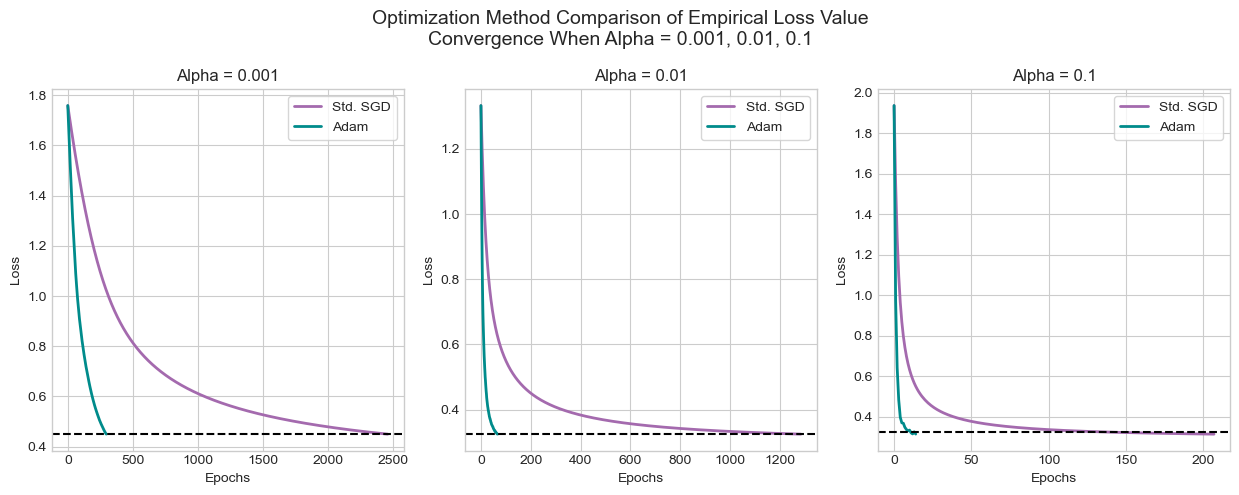

In [680]:
# Plotting the loss values of both models
fig, ax = plt.subplots(1, 3, figsize = (12.5, 5))
loss_plot(ax[0], losses_s_full[alphas[0]], losses_a_full[alphas[0]])
ax[0].set_xlabel("Epochs")
ax[0].legend(["Std. SGD", "Adam"], frameon = True)
ax[0].set_title(f"Alpha = {alphas[0]}")
loss_plot(ax[1], losses_s_full[alphas[1]], losses_a_full[alphas[1]])
ax[1].set_xlabel("Epochs")
ax[1].legend(["Std. SGD", "Adam"], frameon = True)
ax[1].set_title(f"Alpha = {alphas[1]}")
loss_plot(ax[2], losses_s_full[alphas[2]], losses_a_full[alphas[2]])
ax[2].set_xlabel("Epochs")
ax[2].legend(["Std. SGD", "Adam"], frameon = True)
ax[2].set_title(f"Alpha = {alphas[2]}")
fig.suptitle(f"Optimization Method Comparison of Empirical Loss Value\nConvergence When Alpha = {alphas[0]}, {alphas[1]}, {alphas[2]}", fontsize = 14)
plt.tight_layout()

*Code above plots the empirical loss value convergence rates for each of the logistic regression models optimized using the `AdamOptimizer` and `GradientDescentOptimizer` for each of the tested learning rates.*

**Figure 5**

Similarly to **Figure 2**, the plot above provides a visual accompaniment to the output produced by the previous code cell.  As shown, the model optimized with the Adam algorithm converges considerably quicker than the model optimized with standard SGD (i.e. it needed many fewer epochs) for each of the tested learning rates.  This result is evidence that under certain circumstances (i.e. when the learning rates $\alpha_a, \alpha_s$ are appropriately set), the Adam algorithm method can achieve convergence (in the context of decreasing empirical loss value) significantly faster than standard SGD.  The results of this experiment stand as a representation of Adam's boosted efficiencies, displaying how Adam's performance can vastly exceed that of standard SGD even with several choices of the learning rate.

## Comparing Newton's Method and the Adam Algorithm

After experimenting individually with each of these advanced optimization methods, it is useful to compare their performances to each other to understand how each method might outperform the other under certain circumstances.  Considering that these two methods involve notably different computational procedures, I will opt to compare their convergence rates with respect to overall runtime.  Specifically, I will examine the differences in runtime it takes each method to converge (i.e. minimize the empirical loss value) over three different learning rates (similarly to **Experiment 2** from above).  In this comparison, I will again use a pre-selected loss-value tolerance to determine convergence (note that there will be a different tolerance for each learning rate)

In [681]:
# Comparing the convergence rates of Newton's method and Adam with respect to runtime
## Array to store different step sizes and tolerances to compare convergence rates with
alphas = [0.001, 0.01, 0.1]
tols = [0.304, 0.30377, 0.3045]

# Arrays to store the convergence runtimes
rt_n = []
rt_a = []

for i in range(len(alphas)):

    # Initializing each model
    LR_n = LogisticRegression()
    opt_n = NewtonOptimizer(LR_n)
    LR_a = LogisticRegression()
    opt_a = AdamOptimizer(LR_a)

    # Initializing the weights vectors
    LR_n.w = tch.rand((X_train.size()[1]))
    LR_a.w = LR_n.w

    # Running Newton's method
    start_time_n = time.time()
    opt_n.optimize(X_train, y_train, alphas[i], tols[i])
    rt_n.append(time.time() - start_time_n)

    # Running Adam
    start_time_a = time.time()
    opt_a.optimize(X_train, y_train, tols[i], int(X_train.size(0) / 8), alphas[i], beta_1 = 0.9, beta_2 = 0.9, w_0 = LR_a.w) # Using a batch size of (n/8)
    rt_a.append(time.time() - start_time_a)

    # Comparison
    print(f"When alpha = {alphas[i]}")
    if (rt_n[-1] < rt_a[-1]):
        print(f"Newton's Method converges in {rt_n[-1] :.2f} s (~{round((rt_a[-1] / rt_n[-1]), 1)}x Faster)")
        print(f"Adam Converges in            {rt_a[-1] :.2f} s\n----------\n")
    else:
        print(f"Newton's Method converges in {rt_n[-1] :.2f} s ")
        print(f"Adam Converges in            {rt_a[-1] :.2f} s (~{int(rt_n[-1] / rt_a[-1])}x Faster)\n----------\n")

When alpha = 0.001
Newton's Method converges in 1.83 s (~2.9x Faster)
Adam Converges in            5.36 s
----------

When alpha = 0.01
Newton's Method converges in 0.22 s (~19.3x Faster)
Adam Converges in            4.22 s
----------

When alpha = 0.1
Newton's Method converges in 0.02 s (~9.3x Faster)
Adam Converges in            0.15 s
----------



*Code above displays the runtime til convergence for a logistic regression model optimized with Newton's method and a logistic regression model optimized with the Adam algorithm.  Each model is optimized until the empirical loss value reaches a specified tolerance.  The runtimes are compared across three different learning rate step sizes.  The training data used is the empirical penguins classification data.*

The output above compares the runtime between logistic regression models, one optimized with Newton's method and the other with the Adam algorithm.  In this comparison, each model is optimized over the empirical penguins classification data.  The runtime required for each model to yield an empirical loss value of a specified tolerance is tracked and compared across three selected learning rates.  The learning rates of this comparison are $\alpha = 0.001, 0.01, 0.1$,  and the corresponding tolerances for each model given the current learning rates are $0.304, 0.30377, 0.304$.  As clearly depicted above, the model employing Newton's method considerably outperforms the model using the Adam algorithm across all three tested learning rates.  Based on this comparison alone, it would appear that Newton's method is far more efficient than the Adam algorithm for optimization.  However, note that the training data used in this comparison has relatively few features, which likely favors Newton's method over Adam (primarily due to the fact that the expensive computation of Newton's method is not amplified by a vast number of features).  Thus, it is useful to recreate this comparison on data with many more features, and observe any notable similarities or differences $-$ leading into the comparison below:

In [682]:
# Comparing the convergence rates of Newton's method and Adam with respect to runtime - part 2
## Generating high-dimensional data for binary classification - code provided by Prof. Chodrow
def classification_data(n_points = 500, noise = 0.2, p_dims = 250):
    y = tch.arange(n_points) >= int(n_points / 2)
    y = 1.0 * y
    X = y[:, None] + tch.normal(0.0, noise, size = (n_points,p_dims))
    X = tch.cat((X, tch.ones((X.shape[0], 1))), 1)
    
    return X, y
X_sim, y_sim = classification_data(noise = 0.3)

# Array to store different step sizes and tolerances to compare convergence rates with
alphas = [0.001, 0.01, 0.1]
tols = [0.4, 0.3, 0.2]

# Arrays to store the convergence runtimes
rt_n = []
rt_a = []

for i in range(len(alphas)):

    # Initializing each model
    LR_n = LogisticRegression()
    opt_n = NewtonOptimizer(LR_n)
    LR_a = LogisticRegression()
    opt_a = AdamOptimizer(LR_a)

    # Initializing the weights vectors
    LR_n.w = tch.rand((X_sim.size()[1]))
    LR_a.w = LR_n.w

    # Running Newton's method
    start_time_n = time.time()
    opt_n.optimize(X_sim, y_sim, alphas[i], tols[i])
    rt_n.append(time.time() - start_time_n)

    # Running Adam
    start_time_a = time.time()
    opt_a.optimize(X_sim, y_sim, tols[i], int(X_train.size(0) / 8), alphas[i], beta_1 = 0.9, beta_2 = 0.9, w_0 = LR_a.w) # Using a batch size of (n/8)
    rt_a.append(time.time() - start_time_a)

    # Comparison
    print(f"When alpha = {alphas[i]}")
    if (rt_n[-1] < rt_a[-1]):
        print(f"Newton's Method converges in {rt_n[-1] :.2f} s (~{round((rt_a[-1] / rt_n[-1]), 1)}x Faster)")
        print(f"Adam Converges in            {rt_a[-1] :.2f} s\n----------\n")
    else:
        print(f"Newton's Method converges in {rt_n[-1] :.2f} s ")
        print(f"Adam Converges in            {rt_a[-1] :.2f} s (~{int(rt_n[-1] / rt_a[-1])}x Faster)\n----------\n")

When alpha = 0.001
Newton's Method converges in 6.27 s 
Adam Converges in            0.25 s (~24x Faster)
----------

When alpha = 0.01
Newton's Method converges in 0.90 s 
Adam Converges in            0.04 s (~25x Faster)
----------

When alpha = 0.1
Newton's Method converges in 0.66 s 
Adam Converges in            0.01 s (~80x Faster)
----------



*Code above displays the runtime til convergence for a logistic regression model optimized with Newton's method and a logistic regression model optimized with the Adam algorithm.  Each model is optimized until the empirical loss value reaches a specified tolerance.  The runtimes are compared across three different learning rate step sizes.  The training data used in generated classification data with $250$ features.*

The output above again compares the runtime between logistic regression models, one optimized with Newton's method and the other with the Adam algorithm.  Note that the training data used in this comparison is another generated binary classification data set.  In this data set, each data point has $250$ features, much more than each data point from the empirical penguins classification data set.  The runtime required for each model to yield an empirical loss value of a specified tolerance is tracked and compared across three selected learning rates.  The learning rates of this comparison are again $\alpha = 0.001, 0.01, 0.1$, and the corresponding tolerances for each model given the current learning rates are now $0.4, 0.3, 0.32$.  This time, as clearly depicted above, the model employing the Adam algorithm method considerably outperforms the model using Newton's method across all three tested learning rates.  In this comparison, the performances of each optimization method have completely swapped with respect to the first runtime comparison.  This is likely due to the fact the higher-dimensional generated data makes for expensive Hessian matrix/Hessian inversion computation for Newton's method that the Adam algorithm does not experience.  Thus, it appears that the performance of each optimization method over the other depends significantly on the number of features found in the data.

# Discussion

The primary goals of this brief analysis were to investigate, implement, and experiment with advanced optimization methods.   The two particular advanced optimization techniques explored in this study are **Newton's Method** and the **Adam** optimization algorithm.  Each of these advanced, boosted-efficiency optimization techniques incorporates extra mathematical/statistical information that is not computed/considered in basic optimization schemes (i.e. standard gradient descent).  In Newton's method, the gradient descent procedure is sped up using 2nd order information $-$ the Hessian matrix $\mathbf{H(w)}$ of the empirical loss function $L(\mathbf{w})$ with respect to the weights vector $\mathbf{w}$.  This 2nd order information allows Newton's method to achieve faster optimization as it considers the curvature of the empirical loss/objective function.  The Adam algorithm boosts optimization efficiency through the computation and use of the 1st and 2nd moments of the empirical loss/objective function.  In using these gradient moments, the Adam algorithm is able to conduct rapid optimization with dynamic, powerful momentum exploitation while also pushing past/through saddle points, plateaus, or local minima in the empirical loss function.  The Adam algorithm also achieves faster optimization through leveraging stochastic processes.  Compared to their respective counterparts of standard gradient descent and standard stochastic gradient descent (SGD), both Newton's method and Adam can significantly outperform basic optimization methods under many circumstances.  Yet, while in many cases their advanced techniques are preferable, they each possess some key limitations and will not always yield the peak performance across the board.

To investigate the advantages and limitations of Newton's method and Adam, I conducted several experiments with each individual optimization technique as well as compared the two techniques to each other.  

<u>Analyzing Newton's method</u>:

I found that on linearly separable, low-dimensional generated data, this method was easily able to minimize the empirical loss function and achieve $100\%$ classification accuracy.  Further,(on the empirical penguins classification data) with an appropriately selected learning rate $\alpha$, Newton's method was able to minimize the empirical loss value (achieve convergence) in significantly fewer iterations than standard gradient descent.  Specifically, Newton's method converged roughly $15\times$ faster than standard gradient descent.  However, while Newton's method strongly outperforms standard gradient descent with an appropriate learning rate, if the learning rate is set too high, Newton's method fails to converge entirely.  Thus, the benefits of Newton's method are limited by the choice of $\alpha$, which may suggest that in some scenarios, standard gradient descent is the desirable approach.

<u>Analyzing the Adam algorithm</u>:

Similarly to Newton's method, I found that the Adam algorithm was again able to easily minimize the empirical loss function and achieve $100\%$ classification accuracy on the low-dimensional generated data.  Additionally (on the empirical penguins classification data), across several selected learning rates, the Adam algorithm was able to minimize the empirical loss function (i.e. achieve convergence) considerably faster (i.e. in far fewer iterations) than standard stochastic gradient descent.

<u>Comparing Newton's method and the Adam algorithm</u>:

Given the fact that Newton's method and the Adam algorithm perform quite different computation procedures, simply comparing each method optimization iteration-for-optimization iteration is not the most effective method of comparison.  Thus, these methods were compared in terms of the overall runtime required to achieve convergence.  Specifically, the runtime necessary for each method to yield an empirical loss value of a certain loss-value tolerance was tracked over several selected learning rates.  This was likely due to the fact that the 2nd order information of Newton's method had a more significant impact on optimization than the momentum components of Adam with lower-dimensional data.  Interestingly though, I found that the better-performing optimization method depended heavily on the nature of the training data used for optimization.  Trained on the empirical penguins classification data, which has relatively few data points and features, I found that Newton's method was able to minimize the empirical loss function (achieve convergence) exceptionally faster than the Adam algorithm.  However, when trained on a new set of generated data with a much larger number of features, the Adam algorithm substantially outperformed Newton's method on the basis of convergence runtime.  I suspect that this reversal of optimization method performance is attributable to the computationally expensive processes of computing/inverting the Hessian matrix $\mathbf{H(w)}$ in Newton's method, which the Adam algorithm does not employ.

Lastly, from this study, I've had the opportunity to dive into the complex mathematical and algorithmic properties under the hood of two famous advanced optimization techniques.  Exploring these methods of advanced optimization provides some valuable insight into how various types of optimization problems can be efficiently solved simply by following a different set of steps.  Also, one of the most crucial insights about these advanced optimization strategies derived from this study is understanding the specific, yet plausible, circumstances in which these high-efficiency methods actually break down or lose their beneficial qualities.  Overall, in exploring Newton's method and the Adam algorithm, I've been able to develop my understanding of the complexity and diversity of optimization processes in machine learning, gaining new knowledge into how the specific characteristics of a given ML task and the available data resources strongly influence the best choice of model-fitting/optimization technique.

### References

Kingma, Diederik P, and Jimmy Lei Ba. 2015. “Adam: A Method for Stochastic Gradient Descent.” In ICLR: ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍International ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Conference ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍on ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Learning ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Representations, 1–15. ICLR US.